In [4]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model, write_sbml_model
from experiments.fast_dFBA import setup_drawdown
from utils.cobra_utils import get_or_create_exchange, set_active_bound

# Load the model
model = read_sbml_model("../model/Rpom_05.xml")
setup_drawdown(model)
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")
ex_o2 = model.reactions.get_by_id("EX_o2")

# Set ATP maintenance flux to 3
model.reactions.get_by_id("ATPM").lower_bound = 25
model.reactions.get_by_id("ATPM").upper_bound = 25

set_active_bound(ex_ace, -20)
write_sbml_model(model, "for_fluxer.sbml")

ValueError: The lower bound must be less than or equal to the upper bound (25 <= 0.0).

In [16]:
model.reactions.get_by_id("PHB-STORAGE-RXN").metabolites

{<Metabolite PHB-MONOMER[c] at 0x7f9aabb63d60>: -10.19061976,
 <Metabolite PHB-STORAGE[c] at 0x7f9aab05c070>: 1.0}

/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/mica/.pyenv/versions/3.10.4/envs/rpom/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


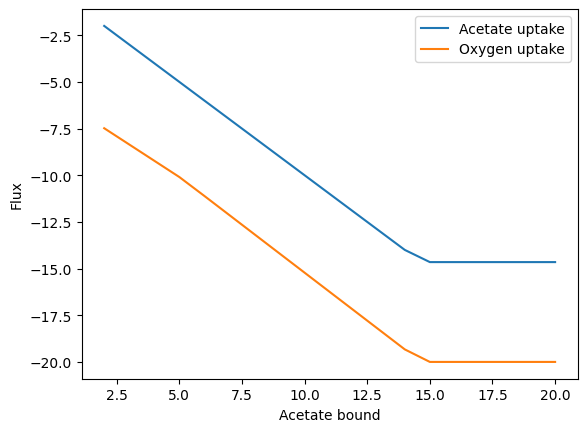

In [3]:
# Find which metabolite(s) are limiting when acetate uptake is >20
fig, ax1 = plt.subplots()

x = np.arange(-20, -1, 1)
uptake_rate = []
o2_rate = []
for bound in x:
    with model:
        set_active_bound(ex_ace, bound)
        sol = model.optimize()
        uptake_rate.append(sol.fluxes["EX_ac"])
        o2_rate.append(sol.fluxes["EX_o2"])

ax1.plot(-x, uptake_rate, label="Acetate uptake")
ax1.plot(-x, o2_rate, label="Oxygen uptake")
ax1.set_xlabel("Acetate bound")
ax1.set_ylabel("Flux")
ax1.legend()

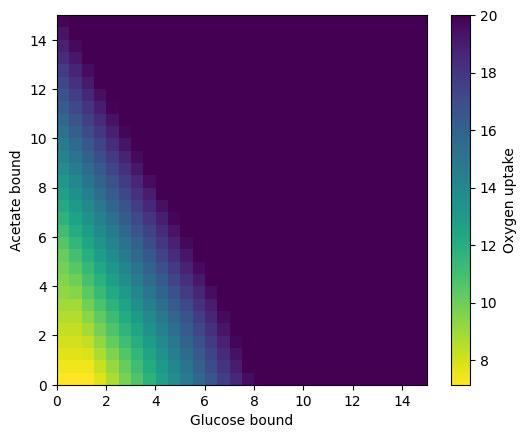

In [31]:
import warnings
import multiprocessing
# Heatmap of oxygen uptake vs. glucose and acetate uptake

fig, ax1 = plt.subplots()

x = np.arange(0, 15, 0.5)
y = np.arange(0, 15, 0.5)
Z = np.zeros((len(y), len(x)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    def get_row(row_y, x_s):
        result=[]
        for _x in x_s:
            with model:
                set_active_bound(ex_glc, -_x)
                set_active_bound(ex_ace, -row_y)
                sol = model.optimize()
                result.append(-sol.fluxes["EX_o2"])
        return result
    
    with multiprocessing.Pool(4) as pool:
        Z = np.array(list(pool.starmap(get_row, [(row_y, x) for row_y in y])))

mappable = ax1.imshow(Z, origin='lower', cmap="viridis_r", extent=(0, 15, 0, 15))
ax1.set_xlabel("Glucose bound")
ax1.set_ylabel("Acetate bound")

fig.colorbar(mappable, label="Oxygen uptake")

In [32]:
import pandas as pd

with model:
    set_active_bound(ex_ace, -20)
    sol = model.optimize()

o2_c = model.metabolites.get_by_id("OXYGEN-MOLECULE[c]")
o2_reactions = pd.DataFrame([{"Reaction": rxn, "Flux" : rxn.flux} for rxn in o2_c.reactions])
o2_reactions["Abs Flux"] = o2_reactions["Flux"].abs()

print(o2_reactions.sort_values("Abs Flux", ascending=False))

                                             Reaction       Flux   Abs Flux
73   O2tpp: OXYGEN-MOLECULE[p] <=> OXYGEN-MOLECULE[c]  20.000000  20.000000
40  CYTOCHROME-C-OXIDASE-RXN: 4.0 Cytochromes-C-Re...  19.999774  19.999774
19  CATAL-RXN: 2.0 HYDROGEN-PEROXIDE[c] --> OXYGEN...   0.000113   0.000113
13  PROTOPORGENOXI-RXN: 3.0 OXYGEN-MOLECULE[c] + P...   0.000057   0.000057
5   RXN0-1461: COPROPORPHYRINOGEN_III[c] + OXYGEN-...   0.000057   0.000057
..                                                ...        ...        ...
25  RXN-17344: CPD-18746[c] + OXYGEN-MOLECULE[c] <...   0.000000   0.000000
24  RXN-17646: CPD-323[c] + NADH[c] + OXYGEN-MOLEC...   0.000000   0.000000
23  4-HYDROXYPHENYLPYRUVATE-DIOXYGENASE-RXN: OXYGE...   0.000000   0.000000
22  RXN0-2042: CPD-207[c] + NADPH[c] + OXYGEN-MOLE...   0.000000   0.000000
30  RXN-8665: OXYGEN-MOLECULE[c] + TRP[c] --> N-FO...   0.000000   0.000000

[74 rows x 3 columns]


In [ ]:
model.reactions.get_by_id("CYTOCHROME-C-OXIDASE-RXN")

Reaction identifier,CYTOCHROME-C-OXIDASE-RXN
Name,
Memory address,0x7f17d8ddf700
Stoichiometry,4.0 Cytochromes-C-Reduced[p] + OXYGEN-MOLECULE[c] + 8.0 PROTON[c] --> 4.0 Cytochromes-C-Oxidized[p] + 4.0 PROTON[p] + 2.0 WATER[c] 4.0 a reduced c-type cytochrome + oxygen + 8.0 H+ --> 4.0 an oxidized c-type cytochrome + 4.0 H+ + 2.0 H2O
GPR,SPO3073 and SPO3076 and SPO1383 and SPO3523 and SPO3524 and SPO3525 and SPO3526 and G1RHL-427 and...
Lower bound,0.0
Upper bound,1000.0


In [39]:
import pandas as pd

with model:
    set_active_bound(ex_ace, -20)
    sol = model.optimize()

acet_p = model.metabolites.get_by_id("ACET[p]")
acet_reactions = pd.DataFrame([{"Reaction": rxn, "Flux" : rxn.flux} for rxn in acet_p.reactions])
acet_reactions["Abs Flux"] = acet_reactions["Flux"].abs()

acet_reactions.sort_values("Abs Flux", ascending=False).head(20)

,Reaction,Flux,Abs Flux
0,ACtex: ACET[e] <=> ACET[p],14.652628,14.652628
14,TRANS-RXN1G48-5-ZN+2/ACET//ZN+2/ACET.21.: ACET...,12.745914,12.745914
9,TRANS-RXN1G48-5-AMMONIUM/ACET//AMMONIUM/ACET.2...,1.906714,1.906714
3,TRANS-RXN1G48-5-FE+3/ACET//FE+3/ACET.21.: ACET...,0.000000,0.000000
4,TRANS-RXN1G48-5-PROTON/ACET//PROTON/ACET.25.: ...,0.000000,0.000000
1,TRANS-RXN1G48-5-K+/ACET//K+/ACET.17.: ACET[p] ...,0.000000,0.000000
2,TRANS-RXN1G48-5-TRIMETHYLSULFONIUM/ACET//TRIME...,0.000000,0.000000
6,TRANS-RXN1G48-5-NI+2/ACET//NI+2/ACET.21.: ACET...,0.000000,0.000000
5,TRANS-RXN1G48-5-FE+2/ACET//FE+2/ACET.21.: ACET...,0.000000,0.000000
8,TRANS-RXN1G48-5-CU+2/ACET//CU+2/ACET.21.: ACET...,0.000000,0.000000


In [46]:
model.reactions.get_by_id("TRANS-RXN1G48-5-ZN+2/ACET//ZN+2/ACET.21.")
model.reactions.get_by_id("TRANS-RXN1G48-5-AMMONIUM/ACET//AMMONIUM/ACET.29.")


Reaction identifier,TRANS-RXN1G48-5-AMMONIUM/ACET//AMMONIUM/ACET.29.
Name,TRANS-RXN1G48-5-AMMONIUM/ACET//AMMONIUM/ACET.29.
Memory address,0x7f993ea98700
Stoichiometry,ACET[p] + AMMONIUM[p] --> ACET[c] + AMMONIUM[c] acetate + ammonium --> acetate + ammonium
GPR,G1G48-1847
Lower bound,0.0
Upper bound,1000.0


In [ ]:
import pandas as pd

with model:
    set_active_bound(ex_ace, -20)
    sol = model.optimize()

proton_c = model.metabolites.get_by_id("PROTON[c]")
proton_reactions = pd.DataFrame([{"Reaction": rxn, "Flux" : rxn.flux} for rxn in proton_c.reactions])
proton_reactions["Abs Flux"] = proton_reactions["Flux"].abs()

proton_reactions.sort_values("Abs Flux", ascending=False).head(20)

,Reaction,Flux,Abs Flux
777,ATPSYN-RXN: ATP[c] + 3.0 PROTON[c] + WATER[c] ...,-44.553733,44.553733
806,1.10.2.2-RXN: CPD-9958[c] + 2.0 Cytochromes-C-...,39.966283,39.966283
786,ATPM: ATP[c] + WATER[c] --> ADP[c] + PROTON[c]...,25.000000,25.000000
898,1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CP...,21.340318,21.340318
851,CYTOCHROME-C-OXIDASE-RXN: 4.0 Cytochromes-C-Re...,19.999774,19.999774
234,PYRUVATEORTHOPHOSPHATE-DIKINASE-RXN: ATP[c] + ...,-15.146195,15.146195
386,GLYCERATE-DEHYDROGENASE-RXN: GLYCERATE[c] + NA...,-10.004701,10.004701
510,RXN0-300: GLYCERATE[c] + NADP[c] <=> NADPH[c] ...,10.004701,10.004701
455,RXN0-5224: HCO3[c] + PROTON[c] <=> CARBON-DIOX...,-9.826729,9.826729
679,RXN-5901: CPD-650[c] + NADP[c] <=> ACETOACETYL...,-9.473889,9.473889


In [ ]:
# Find which metabolite(s) are limiting when acetate uptake is >20
with model:
    # ex_glc.lower_bound = -10
    ex_ace.lower_bound = -20
    sol = model.optimize()

def reaction_fluxes(metabolite, threshold=0):
    metabolite = model.metabolites.get_by_id(metabolite)
    print(f"{metabolite.id} ({metabolite.name})")
    for rxn in metabolite.reactions:
        if threshold is None or abs(rxn.flux) > threshold:
            print(f"\t{rxn.id} ({rxn.flux:.4g})")
            print(f"\t\t{rxn.reaction}")

reaction_fluxes("ACETYL-COA[c]")
reaction_fluxes("CPD-208[c]")


ACETYL-COA[c] (acetyl-CoA)
	CITSYN-RXN (0.3354)
		ACETYL-COA[c] + OXALACETIC_ACID[c] + WATER[c] --> CIT[c] + CO-A[c] + PROTON[c]
	ACETYL-COA-CARBOXYLTRANSFER-RXN (0.4933)
		ACETYL-COA[c] + ATP[c] + HCO3[c] --> ADP[c] + MALONYL-COA[c] + PROTON[c] + Pi[c]
	2-ISOPROPYLMALATESYN-RXN (0.09488)
		2-KETO-ISOVALERATE[c] + ACETYL-COA[c] + WATER[c] --> 3-CARBOXY-3-HYDROXY-ISOCAPROATE[c] + CO-A[c] + PROTON[c]
	MALYL-COA-LYASE-RXN (9.238)
		ACETYL-COA[c] + GLYOX[c] --> CPD-208[c]
	SERINE-O-ACETTRAN-RXN (0.01943)
		ACETYL-COA[c] + SER[c] --> ACETYLSERINE[c] + CO-A[c]
	2.3.1.180-RXN (0.07047)
		ACETYL-COA[c] + MALONYL-ACP[c] + PROTON[c] --> Acetoacetyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	ACETYL-COA-ACETYLTRANSFER-RXN (9.474)
		2.0 ACETYL-COA[c] <=> ACETOACETYL-COA[c] + CO-A[c]
	PDH (14.53)
		CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[c] + CARBON-DIOXIDE[c] + NADH[c]
	ACETATE--COA-LIGASE-RXN (14.67)
		ACET[c] + ATP[c] + CO-A[c] --> ACETYL-COA[c] + AMP[c] + PPI[c]
	ACETALD-DEHYDROG-RXN (-0.00014

In [ ]:
reaction_fluxes("MALONYL-COA[c]")

MALONYL-COA[c] (malonyl-CoA)
	RXN-9654 (0.13)
		MALONYL-COA[c] + Myristoyl-ACPs[c] + PROTON[c] <=> 3-oxo-palmitoyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	ACETYL-COA-CARBOXYLTRANSFER-RXN (0.94)
		ACETYL-COA[c] + ATP[c] + HCO3[c] --> ADP[c] + MALONYL-COA[c] + PROTON[c] + Pi[c]
	RXN-9651 (0.13)
		MALONYL-COA[c] + Octanoyl-ACPs[c] + PROTON[c] <=> 3-oxo-decanoyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	RXN-9648 (0.13)
		Butanoyl-ACPs[c] + MALONYL-COA[c] + PROTON[c] <=> 3-oxo-hexanoyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	RXN-9652 (0.13)
		Decanoyl-ACPs[c] + MALONYL-COA[c] + PROTON[c] <=> 3-oxo-dodecanoyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	RXN-9632 (0.13)
		MALONYL-COA[c] + PROTON[c] + Palmitoyl-ACPs[c] --> 3-oxo-stearoyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	RXN-9653 (0.13)
		Dodecanoyl-ACPs[c] + MALONYL-COA[c] + PROTON[c] <=> 3-oxo-myristoyl-ACPs[c] + CARBON-DIOXIDE[c] + CO-A[c]
	RXN-9650 (0.13)
		Hexanoyl-ACPs[c] + MALONYL-COA[c] + PROTON[c] <=> 3-Oxo-octanoyl-ACPs[c] + CARBON-DIOXIDE

In [3]:
import escher
from escher import Builder

builder = Builder(model=model, full_screen_button=False)
builder.height = 800
builder.reaction_data = sol.fluxes

builder

NameError: name 'sol' is not defined

In [ ]:
reaction_fluxes("KDO2-LIPID-A[c]", threshold=None)
reaction_fluxes("KDO2-LAUROYL-LIPID-IVA[c]", threshold=None)
reaction_fluxes("KDO2-LIPID-IVA[c]", threshold=None)

KDO2-LIPID-A[c] (alpha-D-Kdo-(2->4)-alpha-D-Kdo-(2->6)-lipid A)
	MYRISTOYLACYLTRAN-RXN (0.00)
		KDO2-LAUROYL-LIPID-IVA[c] + Myristoyl-ACPs[c] --> ACP[c] + KDO2-LIPID-A[c]
KDO2-LAUROYL-LIPID-IVA[c] (alpha-Kdo-(2->4)-alpha-Kdo-(2->6)-(lauroyl)-lipid IVA)
	LAUROYLACYLTRAN-RXN (0.00)
		Dodecanoyl-ACPs[c] + KDO2-LIPID-IVA[c] --> ACP[c] + KDO2-LAUROYL-LIPID-IVA[c]
	MYRISTOYLACYLTRAN-RXN (0.00)
		KDO2-LAUROYL-LIPID-IVA[c] + Myristoyl-ACPs[c] --> ACP[c] + KDO2-LIPID-A[c]
KDO2-LIPID-IVA[c] (alpha-Kdo-(2->4)-alpha-Kdo-(2->6)-lipid IVA)
	TRANS-RXN1RFH-44-KDO2-LIPID-IVA//KDO2-LIPID-IVA.31. (0.00)
		KDO2-LIPID-IVA[c] --> KDO2-LIPID-IVA[p]
	KDOTRANS2-RXN (0.00)
		CMP-KDO[c] + KDO-LIPID-IVA[c] --> CMP[c] + KDO2-LIPID-IVA[c] + PROTON[c]
	PALMITOTRANS-RXN (0.00)
		KDO2-LIPID-IVA[c] + Palmitoleoyl-ACPs[c] --> ACP[c] + KDO2-PALMITOLEOYL-LIPID-IVA[c]
	LAUROYLACYLTRAN-RXN (0.00)
		Dodecanoyl-ACPs[c] + KDO2-LIPID-IVA[c] --> ACP[c] + KDO2-LAUROYL-LIPID-IVA[c]


In [ ]:
with model:
    # ex_glc.lower_bound = -10
    ex_ace.lower_bound = -20

    # Add CPD-12258 supply
    cpd12258 = model.metabolites.get_by_id("CPD-12258[c]")
    cpd12258_supp = model.add_boundary(cpd12258, type="sink", reaction_id="CPD-12258_supply")

    # Add C6 sink
    # c6 = model.metabolites.get_by_id("C6[c]")
    # c6_supp = model.add_boundary(c6, type="sink", reaction_id="C6_supply")
    

    # Add KDO2-LIPID-A supply
    # kdo2 = model.metabolites.get_by_id("KDO2-LIPID-IVA-COLD[c]")
    # kdo2_supp = model.add_boundary(kdo2, type="sink", reaction_id="KDO2-LIPID-A_supply")

    # Add CPD0-2283[p] supply
    # cpd0 = model.metabolites.get_by_id("CPD0-2283[p]")
    # cpd0_supp = model.add_boundary(cpd0, type="sink", reaction_id="CPD0-2283_supply")

    sol = model.optimize()
    print(sol.objective_value)
    # print(c6_supp)
    # print(kdo2_supp.flux)
    print(sol.fluxes["CPD-12258_supply"])

sp = sol.shadow_prices.sort_values(ascending=False).head(10)
sp

0.4841246921218606
0.0


C3[c]                      1.061535
CPD-13704[c]               0.520827
ADENOSYLCOBINAMIDE[c]      0.514055
ADENOSYLCOBINAMIDE-P[c]    0.503568
CPD-13708[c]               0.492208
CPD-13680[c]               0.492208
CPD-13711[c]               0.475604
CPD-17640[c]               0.472764
16-HYDROXYPALMITATE[c]     0.472764
CPD-10826[c]               0.465773
Name: shadow_prices, dtype: float64

In [ ]:
with model:
    # ex_glc.lower_bound = -10
    ex_ace.lower_bound = -20

    # Add CPD-12258 supply
    # cpd12258 = model.metabolites.get_by_id("CPD-12258[c]")
    # cpd12258_supp = model.add_boundary(cpd12258, type="sink", reaction_id="CPD-12258_supply")

    # Add C6 sink
    # c6 = model.metabolites.get_by_id("C6[c]")
    # c6_supp = model.add_boundary(c6, type="sink", reaction_id="C6_supply")
    

    # Add KDO2-LIPID-A supply
    # kdo2 = model.metabolites.get_by_id("KDO2-LIPID-IVA-COLD[c]")
    # kdo2_supp = model.add_boundary(kdo2, type="sink", reaction_id="KDO2-LIPID-A_supply")

    # Add CPD0-2283[p] supply
    # cpd0 = model.metabolites.get_by_id("CPD0-2283[p]")
    # cpd0_supp = model.add_boundary(cpd0, type="sink", reaction_id="CPD0-2283_supply")

    sol = model.optimize()
    print(sol.objective_value)
    # print(c6_supp)
    # print(kdo2_supp.flux)
    # print(sol.fluxes["CPD-12258_supply"] == 0)

sp = sol.shadow_prices.sort_values(ascending=True).head(10)
sp

0.48412469212192066


C6[c]                            -1.654457
C5[c]                            -1.532989
KDO2-LIPID-IVA-COLD[c]           -1.498689
KDO2-LIPID-A[c]                  -1.467667
KDO2-PALMITOLEOYL-LIPID-IVA[c]   -1.297699
KDO2-LAUROYL-LIPID-IVA[c]        -1.266676
CPD0-2283[p]                     -1.130353
CPD0-2278[p]                     -1.107195
KDO2-LIPID-IVA[c]                -1.096708
KDO2-LIPID-IVA[p]                -1.096708
Name: shadow_prices, dtype: float64

In [ ]:
reaction_fluxes("CPD0-2278[p]", threshold=None)
reaction_fluxes("CPD0-2283[p]", threshold=None)
reaction_fluxes("C6[c]", threshold=None)
reaction_fluxes("C5[c]", threshold=None)
reaction_fluxes("C1[c]", threshold=None)
reaction_fluxes("UDP-AAGM-DIAMINOHEPTANEDIOATE[c]", threshold=None)
reaction_fluxes("UDP-AA-GLUTAMATE[c]", threshold=None)
reaction_fluxes("CPD0-1456[c]", threshold=None)
reaction_fluxes("UDP-N-ACETYLMURAMATE[c]", threshold=None)
reaction_fluxes("UDP-ACETYL-CARBOXYVINYL-GLUCOSAMINE[c]", threshold=None)
reaction_fluxes("UDP-N-ACETYL-D-GLUCOSAMINE[c]", threshold=0)
reaction_fluxes("N-ACETYL-D-GLUCOSAMINE-1-P[c]", threshold=None)
reaction_fluxes("GLUCOSAMINE-1P[c]", threshold=None)



CPD0-2278[p] (Two disacharide linked murein units, pentapeptide crosslinked tetrapeptide (A2pm->D-ala) (middle of chain))
	RPOM_provisional_biomass (0)
		0.000223 2-OCTAPRENYL-6-HYDROXYPHENOL[c] + 0.013013 AMMONIUM[c] + 0.295792 ARG[c] + 0.241055 ASN[c] + 54.124831 ATP[c] + 0.005205 CA+2[c] + 0.005205 CL-[c] + 2.5e-05 CO+2[c] + 0.000576 CO-A[c] + 0.017868 CPD-12819[c] + 0.045946 CPD-12819[p] + 0.054154 CPD-17086[c] + 0.02106 CPD-17086[p] + 7e-06 CPD-3[c] + 0.013894 CPD0-2278[p] + 0.133508 CTP[c] + 0.000709 CU+2[c] + 0.09158 CYS[c] + 0.026166 DATP[c] + 0.027017 DCTP[c] + 0.027017 DGTP[c] + 0.026166 DTTP[c] + 0.000223 FAD[c] + 0.006715 FE+2[c] + 0.007808 FE+3[c] + 0.000223 FORMYL-THF-GLU-N[c] + 0.26316 GLN[c] + 0.26316 GLT[c] + 0.612638 GLY[c] + 0.215096 GTP[c] + 0.094738 HIS[c] + 0.290529 ILE[c] + 0.195193 K+[c] + 0.513689 L-ALPHA-ALANINE[c] + 0.241055 L-ASPARTATE[c] + 0.450531 LEU[c] + 0.343161 LYS[c] + 0.000223 METHYLENE-THF-GLU-N[c] + 0.153686 MET[c] + 0.008675 MG+2[c] + 0.000691 MN+

In [ ]:
reaction_fluxes("CPD-13469[c]", threshold=None)

CPD-13469[c] (alpha-D-glucosamine 6-phosphate)
	5.4.2.10-RXN-CPD-13469//GLUCOSAMINE-1P.26. (0.01418)
		CPD-13469[c] <=> GLUCOSAMINE-1P[c]
	L-GLN-FRUCT-6-P-AMINOTRANS-RXN-FRUCTOSE-6P/GLN//CPD-13469/GLT.31. (-0.388)
		FRUCTOSE-6P[c] + GLN[c] <=> CPD-13469[c] + GLT[c]
	GLUCOSAMINE-6-P-DEAMIN-RXN (-0.4022)
		CPD-13469[c] + WATER[c] <=> AMMONIUM[c] + FRUCTOSE-6P[c]
	NAG6PDEACET-RXN-N-ACETYL-D-GLUCOSAMINE-6-P/WATER//CPD-13469/ACET.49. (0)
		N-ACETYL-D-GLUCOSAMINE-6-P[c] + WATER[c] --> ACET[c] + CPD-13469[c]


In [ ]:
with model:
    # ex_glc.lower_bound = -10
    ex_ace.lower_bound = -20

    # Add LIPID supply
    # lipid = model.metabolites.get_by_id("LIPID[c]")
    # lipid_supp = model.add_boundary(lipid, type="sink", reaction_id="LIPID_supply")

    sol = model.optimize()
    print(sol.objective_value)
    # print(sol.fluxes["LIPID_supply"])
    
    sp = sol.shadow_prices.sort_values(ascending=False)

biomass_components = [met.id for met in model.reactions.get_by_id("Rpom_hwa_biomass").metabolites]
sp[biomass_components].sort_values()


0.4841246921217045


LIPID[c]         -8.665649e-01
PROTEIN[c]       -8.577816e-01
COFACTORS[c]     -8.203864e-01
NADP[c]          -4.552869e-01
DNA[c]           -4.507889e-01
NAD[c]           -4.448005e-01
RNA[c]           -4.280858e-01
PHB-STORAGE[c]   -3.584379e-01
ATP[c]           -2.357268e-01
ADP[c]           -2.278619e-01
MUREIN[c]        -1.538337e-02
Pi[c]            -9.714451e-17
WATER[c]         -0.000000e+00
PROTON[c]         2.621614e-03
IONS[c]           3.747637e-03
Name: shadow_prices, dtype: float64

In [ ]:
from cobra.core import Reaction

# Shadow prices of currency metabolites
with model:
    # ex_glc.lower_bound = -10
    ex_ace.lower_bound = -20

    # Add UBIQUINONE-8[c] to CPD-9956[c] reaction
    ubiq8 = model.metabolites.get_by_id("UBIQUINONE-8[c]")
    cpd9956 = model.metabolites.get_by_id("CPD-9956[c]")
    temp = Reaction("ubi8_to_cpd9956", "", "", -1000, 1000)
    temp.add_metabolites({ubiq8: -1, cpd9956: 1})
    model.add_reactions([temp])

    sol = model.optimize()
    print(sol.objective_value)
    print(sol.fluxes["ubi8_to_cpd9956"])
    
    sp = sol.shadow_prices.sort_values(ascending=False)

currency_metabolites = ["ATP[c]",
                        "ADP[c]",
                        "AMP[c]",
                        "NAD[c]",
                        "NADH[c]",
                        "NADP[c]",
                        "NADPH[c]",
                        "FADH2[c]",
                        "FMNH2[c]",
                        "GTP[c]",
                        "GDP[c]",
                        "GMP[c]",
                        "UTP[c]",
                        "ITP[c]",
                        "UDP[c]",
                        "UMP[c]",
                        "CTP[c]",
                        "CDP[c]",
                        "CMP[c]",
                        "WATER[c]",
                        "CARBON-DIOXIDE[c]",
                        "PROTON[c]",
                        "Pi[c]",
                        "UBIQUINONE-8[c]",
                        "UBIQUINONE-9[c]",
                        "UBIQUINONE-10[c]",
                        "UBIQUINONE-6[c]",
                        ]
# {"ATP[c]" : -1, "WATER[c]" : -1, "ADP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
#     {"CTP[c]" : -1, "WATER[c]" : -1, "CDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
#     {"GTP[c]" : -1, "WATER[c]" : -1, "GDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
#     {"UTP[c]" : -1, "WATER[c]" : -1, "UDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
#     {"ITP[c]" : -1, "WATER[c]" : -1, "IDP[c]" : 1, "PROTON[c]": 1, "Pi[c]": 1},
#     {"NADH[c]" : -1, "PROTON[c]": 1, "NAD[c]": 1},
#     {"NADPH[c]" : -1, "PROTON[c]": 1, "NADP[c]": 1},
#     {"FADH2[c]" : -1, "PROTON[c]" : 2, "FAD[c]": 1},
#     {"FMNH2[c]" : -1, "PROTON[c]" : 2, "FMN[c]": 1},
#     {"CPD-9956[c]" : -1, "PROTON[c]" : 2, "UBIQUINONE-8[c]": 1},
#     {"UBIQUINOL-30[c]" : -1, "PROTON[c]" : 2, "UBIQUINONE-6[c]": 1},
#     {"CPD-9957[c]" : -1, "PROTON[c]" : 2, "UBIQUINONE-9[c]" : 1},
#     {"CPD-9958[c]": -1, "PROTON[c]" : 2, "UBIQUINONE-10[c]": 1},
    
#     {"WATER[c]" : -1, "ACETYL-COA[c]" : -1, "PROTON[c]" : 1, "ACET[c]": 1, "CO-A[c]": 1},
#     {"GLT[c]" : -1, "WATER[c]" : -1, "2-KETOGLUTARATE[c]": 1, "AMMONIUM[c]": 1, "PROTON[c]": 2},
#     {"PROTON[p]" : -1, "PROTON[c]": 1}
# ]
sp[currency_metabolites].sort_values()


0.5059029426410818
-2.848180227469327


UBIQUINONE-8[c]     -1.004811
FADH2[c]            -0.651966
NADPH[c]            -0.476243
NADH[c]             -0.469527
NADP[c]             -0.467848
NAD[c]              -0.461133
FMNH2[c]            -0.436509
ATP[c]              -0.224410
GTP[c]              -0.222172
ADP[c]              -0.219374
GDP[c]              -0.217135
AMP[c]              -0.214337
GMP[c]              -0.212099
ITP[c]              -0.204824
CTP[c]              -0.190833
CDP[c]              -0.185796
UTP[c]              -0.182438
CMP[c]              -0.180760
UDP[c]              -0.177402
UMP[c]              -0.172365
WATER[c]            -0.000000
CARBON-DIOXIDE[c]   -0.000000
Pi[c]                0.000000
UBIQUINONE-9[c]      0.000000
UBIQUINONE-6[c]      0.000000
UBIQUINONE-10[c]     0.000000
PROTON[c]            0.001679
Name: shadow_prices, dtype: float64

In [ ]:
reaction_fluxes("UBIQUINONE-8[c]", threshold=None)

UBIQUINONE-8[c] (ubiquinone-8)
	RXN-20992-CPD-9956/OXYGEN-MOLECULE//UBIQUINONE-8/WATER.45. (0)
		2.0 CPD-9956[c] + OXYGEN-MOLECULE[c] --> 2.0 UBIQUINONE-8[c] + 2.0 WATER[c]
	RXN-14970-SUC/UBIQUINONE-8//FUM/CPD-9956.31. (-2.848)
		CPD-9956[c] + FUM[c] <=> SUC[c] + UBIQUINONE-8[c]
	RXN66-550-ETF-Reduced/UBIQUINONE-8//ETF-Oxidized/CPD-9956/PROTON.55. (0)
		ETF-Reduced[c] + UBIQUINONE-8[c] --> CPD-9956[c] + ETF-Oxidized[c] + PROTON[c]
	RXN-14903-PRO/UBIQUINONE-8//L-DELTA1-PYRROLINE_5-CARBOXYLATE/CPD-9956/PROTON.67. (0)
		PRO[c] + UBIQUINONE-8[c] --> CPD-9956[c] + L-DELTA1-PYRROLINE_5-CARBOXYLATE[c] + PROTON[c]


In [ ]:
lipid_components = ["CPD-12819[c]",
"CPD-12819[p]",
"CPD-17086[c]",
"CPD-17086[p]",
"UNDECAPRENYL-DIPHOSPHATE[c]"
]
sp[lipid_components].sort_values()

UNDECAPRENYL-DIPHOSPHATE[c]   -1.091902
CPD-17086[p]                  -0.626129
CPD-17086[c]                  -0.615642
CPD-12819[p]                  -0.575881
CPD-12819[c]                  -0.565395
Name: shadow_prices, dtype: float64

In [ ]:
reaction_fluxes("UNDECAPRENYL-DIPHOSPHATE[c]", threshold=0)
reaction_fluxes("DELTA3-ISOPENTENYL-PP[c]", threshold=0)

UNDECAPRENYL-DIPHOSPHATE[c] (di-trans,octa-cis-undecaprenyl diphosphate)
	UNDECAPRENYL-DIPHOSPHATASE-RXN (0.007092)
		UNDECAPRENYL-DIPHOSPHATE[c] + WATER[c] --> CPD-9646[c] + PROTON[c] + Pi[c]
	RXN-16689 (0.003546)
		2.0 C6[c] --> CPD0-2283[p] + 2.0 PROTON[c] + 2.0 UNDECAPRENYL-DIPHOSPHATE[c]
	LIPID-RXN (0.04645)
		0.186220192 CPD-12819[c] + 0.478848946 CPD-12819[p] + 0.564392674 CPD-17086[c] + 0.219487198 CPD-17086[p] + 0.000573 UNDECAPRENYL-DIPHOSPHATE[c] --> LIPID[c]
	RXN-8999 (2.662e-05)
		8.0 DELTA3-ISOPENTENYL-PP[c] + FARNESYL-PP[c] --> 8.0 PPI[c] + UNDECAPRENYL-DIPHOSPHATE[c]
DELTA3-ISOPENTENYL-PP[c] (isopentenyl diphosphate)
	IPPISOM-RXN (-0.001022)
		DELTA3-ISOPENTENYL-PP[c] <=> CPD-4211[c]
	FPPSYN-RXN (0.0001346)
		DELTA3-ISOPENTENYL-PP[c] + GERANYL-PP[c] --> FARNESYL-PP[c] + PPI[c]
	GPPSYN-RXN (0.0001346)
		CPD-4211[c] + DELTA3-ISOPENTENYL-PP[c] --> GERANYL-PP[c] + PPI[c]
	RXN-8999 (2.662e-05)
		8.0 DELTA3-ISOPENTENYL-PP[c] + FARNESYL-PP[c] --> 8.0 PPI[c] + UNDECAPRENYL-DIPH

In [ ]:
sp[["DELTA3-ISOPENTENYL-PP[c]", "FARNESYL-PP[c]"]]

DELTA3-ISOPENTENYL-PP[c]   -0.100058
FARNESYL-PP[c]             -0.298427
Name: shadow_prices, dtype: float64

In [ ]:
reaction_fluxes("FARNESYL-PP[c]", threshold=0)
reaction_fluxes("GERANYL-PP[c]", threshold=0)
reaction_fluxes("CPD-4211[c]", threshold=0)



FARNESYL-PP[c] ((2E,6E)-farnesyl diphosphate)
	FPPSYN-RXN (0.0001346)
		DELTA3-ISOPENTENYL-PP[c] + GERANYL-PP[c] --> FARNESYL-PP[c] + PPI[c]
	RXN-8999 (2.662e-05)
		8.0 DELTA3-ISOPENTENYL-PP[c] + FARNESYL-PP[c] --> 8.0 PPI[c] + UNDECAPRENYL-DIPHOSPHATE[c]
	RXN-8992 (0.000108)
		5.0 DELTA3-ISOPENTENYL-PP[c] + FARNESYL-PP[c] --> OCTAPRENYL-DIPHOSPHATE[c] + 5.0 PPI[c]
GERANYL-PP[c] (geranyl diphosphate)
	FPPSYN-RXN (0.0001346)
		DELTA3-ISOPENTENYL-PP[c] + GERANYL-PP[c] --> FARNESYL-PP[c] + PPI[c]
	GPPSYN-RXN (0.0001346)
		CPD-4211[c] + DELTA3-ISOPENTENYL-PP[c] --> GERANYL-PP[c] + PPI[c]
CPD-4211[c] (prenyl diphosphate)
	IPPISOM-RXN (-0.001022)
		DELTA3-ISOPENTENYL-PP[c] <=> CPD-4211[c]
	GPPSYN-RXN (0.0001346)
		CPD-4211[c] + DELTA3-ISOPENTENYL-PP[c] --> GERANYL-PP[c] + PPI[c]
	RXN0-884 (0.001156)
		HYDROXY-METHYL-BUTENYL-DIP[c] + 2.0 PROTON[c] + 2.0 Reduced-ferredoxins[c] --> CPD-4211[c] + 2.0 Oxidized-ferredoxins[c] + WATER[c]


In [ ]:
etc_rxns = [rxn for rxn in model.reactions
            if any("ubi" in met.id.lower()
                   or "cyto" in met.id.lower()
                   or "ubi" in met.name.lower()
                   or "cyto" in met.name.lower() for met in rxn.metabolites)]
for rxn in etc_rxns:
    print(f"{rxn.id},{rxn.reaction}")

1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-10//ETF-Oxidized/CPD-9958/PROTON.56.,ETF-Reduced[c] + UBIQUINONE-10[c] <=> CPD-9958[c] + ETF-Oxidized[c] + PROTON[c]
1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-6//ETF-Oxidized/UBIQUINOL-30/PROTON.59.,ETF-Reduced[c] + UBIQUINONE-6[c] <=> ETF-Oxidized[c] + PROTON[c] + UBIQUINOL-30[c]
1.5.5.1-RXN-ETF-Reduced/UBIQUINONE-9//ETF-Oxidized/CPD-9957/PROTON.55.,ETF-Reduced[c] + UBIQUINONE-9[c] <=> CPD-9957[c] + ETF-Oxidized[c] + PROTON[c]
1.6.99.5-RXN-NADH/UBIQUINONE-10/PROTON//NAD/CPD-9958.40.,NADH[c] + 5.0 PROTON[c] + UBIQUINONE-10[c] --> CPD-9958[c] + NAD[c] + 4.0 PROTON[e]
1.6.99.5-RXN-NADH/UBIQUINONE-6/PROTON//NAD/UBIQUINOL-30.43.,NADH[c] + 5.0 PROTON[c] + UBIQUINONE-6[c] --> NAD[c] + 4.0 PROTON[e] + UBIQUINOL-30[c]
1.6.99.5-RXN-NADH/UBIQUINONE-9/PROTON//NAD/CPD-9957.39.,NADH[c] + 5.0 PROTON[c] + UBIQUINONE-9[c] --> CPD-9957[c] + NAD[c] + 4.0 PROTON[e]
2.1.1.64-RXN,CPD-7158[c] + S-ADENOSYLMETHIONINE[c] --> ADENOSYL-HOMO-CYS[c] + CPD-9957[c] + PROTON[c]
BiomassRxn,

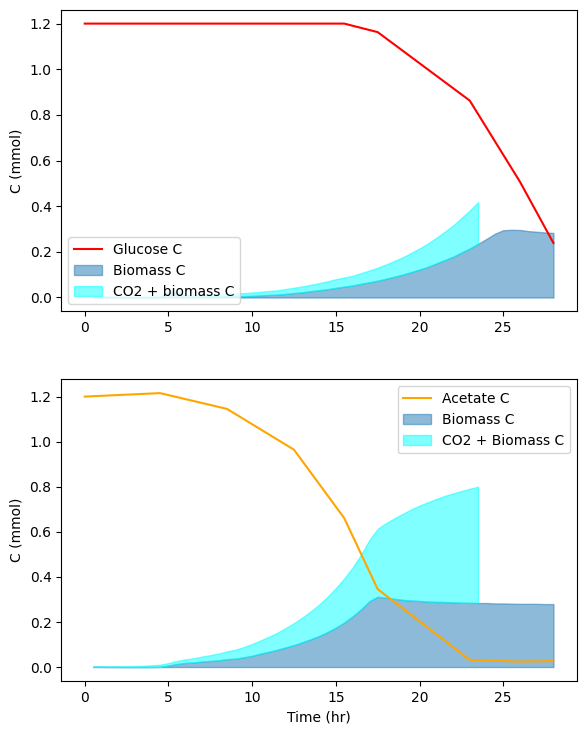

In [113]:
# The data appears to show R. pom taking up acetate incredibly rapidly, but not growing very fast.
# Where is the acetate going?
import pandas as pd

CARBONS_PER_GLUCOSE = 6
CARBONS_PER_ACETATE = 2
CUE_VOLUME = 0.1  # L
glucose_mM = pd.read_excel("../data/clean/CUE2/cue2.xlsx", sheet_name="Glucose", skiprows=1)  # mM
acetate_mM = pd.read_excel("../data/clean/CUE2/cue2.xlsx", sheet_name="Acetate", skiprows=1)  # mM
biomass_C = pd.read_excel("../data/clean/CUE2/cue2.xlsx", sheet_name="C content", skiprows=1)  # umol C / 0.1 L
CO2_cumulative = pd.read_excel("../data/clean/CUE2/cue2.xlsx", sheet_name="CO2 cumulative", skiprows=1)  # umol C / 0.1 L

# convert glucose to mmol C
glucose_mmol_C = glucose_mM.filter(like="Glucose").mean(axis=1) * CARBONS_PER_GLUCOSE * CUE_VOLUME

# convert acetate to mmol C
acetate_mmol_C = acetate_mM.filter(like="Acetate").mean(axis=1) * CARBONS_PER_ACETATE * CUE_VOLUME

# convert biomass_C to mmol C
biomass_mmol_C_glucose = biomass_C["Glucose_mean"] * 10 * CUE_VOLUME / 1000
biomass_mmol_C_acetate = biomass_C["Acetate_mean"] * 10 * CUE_VOLUME / 1000

# convert CO2 to mmol C, discard times >= 24 hr
CO2_t = CO2_cumulative["OD time"]
CO2_t = CO2_t[CO2_t < 24]
CO2_mmol_C_gluc = CO2_cumulative["Glucose_mean"]
CO2_mmol_C_gluc = CO2_mmol_C_gluc[:len(CO2_t)] / 1000
CO2_mmol_C_acet = CO2_cumulative["Acetate_mean"]
CO2_mmol_C_acet = CO2_mmol_C_acet[:len(CO2_t)] / 1000

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(glucose_mM["Time (single)"], glucose_mmol_C, "r-", label="Glucose C")
ax1.fill_between(biomass_C["Time"], biomass_mmol_C_glucose, color="tab:blue", alpha=0.5, label="Biomass C")
ax1.fill_between(CO2_t,
                biomass_mmol_C_glucose[:len(CO2_t)],
                biomass_mmol_C_glucose[:len(CO2_t)] + CO2_mmol_C_gluc,
                color="cyan",
                alpha=0.5,
                label="CO2 + biomass C")

ax2.plot(acetate_mM["Time (single)"], acetate_mmol_C, color="orange", label="Acetate C")
ax2.fill_between(biomass_C["Time"], biomass_mmol_C_acetate, color="tab:blue", alpha=0.5, label="Biomass C")
ax2.fill_between(CO2_t,
                biomass_mmol_C_acetate[:len(CO2_t)],
                biomass_mmol_C_acetate[:len(CO2_t)] + CO2_mmol_C_acet,
                color="cyan",
                alpha=0.5,
                label="CO2 + Biomass C")

ax2.set_xlabel("Time (hr)")
ax1.set_ylabel("C (mmol)")
ax2.set_ylabel("C (mmol)")
ax1.legend()
ax2.legend()

fig.tight_layout()
fig.set_size_inches(6, 8)

In [118]:
initial_acetate = 6.0  # mM
initial_C = 6.0 * 2 * 0.1  # mmol C = mM acetate * 2 carbons/acetate * 0.1 L
print(f"Initial C: {initial_C:.2f} mmol")

final_biomass_C = biomass_C["Acetate_mean"][biomass_C["Time"] == 24].values[0]  # umol C / 0.1 L
final_biomass_C = final_biomass_C / 1000  # mmol C = umol C (in 0.1 L) / 1000
print(f"Final biomass C: {final_biomass_C:.2f} mmol")

final_CO2_cumulative = CO2_cumulative["Acetate_mean"][CO2_cumulative["OD time"] == 24]  # umol C / 0.1 L
final_CO2_cumulative = final_CO2_cumulative.values[0] / 1000  # mmol C = umol C (in 0.1 L) / 100
print(f"Final CO2: {final_CO2_cumulative:.2f} mmol")

print(f"{final_biomass_C:.2f} + {final_CO2_cumulative:.2f} = {final_biomass_C + final_CO2_cumulative:.2f} mmol C final")

Initial C: 1.20 mmol
Final biomass C: 0.28 mmol
Final CO2: 0.53 mmol
0.28 + 0.53 = 0.81 mmol C final
